# 🏠 Problem Definition
# 🎯 Objective: 
# The goal is to determine the Water quality condition based on various environmental parameters.

# 📌 This is a Classification problem, where the objective is to use a machine learning model to predict the exact Water quality status given new input parameters.


In [1]:
# Data Collection
import pandas as pd
import numpy as np

#Vizualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer

# Data partitioning and model tuning
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, KFold

# Calling regression models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

# Model Evaluation
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#  Determining the explanatory power of a model (SHAP) 
import shap  




In [2]:
# 1) First, we will show the available handlers and their formats.
import logging, sys

print("Current root handlers and their format strings:")
for i, h in enumerate(logging.root.handlers):
    fmt = None
    try:
        fmt = h.formatter._fmt if h.formatter else None
    except Exception as e:
        fmt = f"<error reading formatter: {e}>"
    print(i, type(h), "format:", fmt)

# 2)If there are old/broken handlers, we will delete them.
for h in logging.root.handlers[:]:
    logging.root.removeHandler(h)

# 3) We add new, correct formatters and handlers (file + console)
logger = logging.getLogger()         # root logger
logger.setLevel(logging.INFO)

correct_fmt = "%(asctime)s - %(levelname)s - %(message)s"
formatter = logging.Formatter(correct_fmt)

# File handler
fh = logging.FileHandler("Info_Log.log", mode="a", encoding="utf-8")
fh.setFormatter(formatter)
logger.addHandler(fh)

# Console/stream handler (usually useful for Jupyter)
sh = logging.StreamHandler(sys.stdout)
sh.setFormatter(formatter)
logger.addHandler(sh)

# 4) Test: now we write test logs
logger.info("Logging reconfigured successfully (test message).")
logger.error("If you see this message, logging is working.")

# 5) Now our file reading code:
try:
    import pandas as pd
    df = pd.read_csv("water_potability.csv")
    logger.info("Data Set Uploaded Successfully")
except FileNotFoundError as e:
    logger.error("Data Set Not Found: %s", e)
except Exception as e:
    logger.exception("Other error while loading dataset: %s", e)



Current root handlers and their format strings:
2025-08-28 14:48:59,579 - INFO - Logging reconfigured successfully (test message).
2025-08-28 14:48:59,580 - ERROR - If you see this message, logging is working.
2025-08-28 14:48:59,605 - INFO - Data Set Uploaded Successfully


## 📊 Dataset Overview  

Before performing analysis and visualization, let's first take a look at the dataset to understand its structure, features, and available information.


In [3]:
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


# 💧 Water Quality Dataset – Feature Description

## 🔎 Key Features

- **pH**  
  Measure of the acidity or alkalinity of water. A neutral pH is 7; values below 7 indicate acidity, while values above 7 indicate alkalinity.

- **Hardness**  
  Concentration of dissolved calcium and magnesium salts, contributing to water hardness.

- **Solids (TDS)**  
  Total Dissolved Solids in water. High TDS may affect taste, odor, and overall quality.

- **Chloramines**  
  Disinfectant compound formed by mixing chlorine and ammonia, commonly used in water treatment.

- **Sulfate**  
  Concentration of sulfate ions in water. Excessive levels may affect taste and health.

- **Conductivity**  
  Ability of water to conduct electricity, directly related to the concentration of dissolved ions.

- **Organic_carbon**  
  Amount of organic carbon present, indicating possible contamination or pollutants.

- **Trihalomethanes (THMs)**  
  Chemical by-products formed during the disinfection process with chlorine.

- **Turbidity**  
  Cloudiness or haziness of water caused by suspended particles, affecting clarity.

- **Potability**  
  Indicates whether water is safe for human consumption.  
  - `1` → Drinkable  
  - `0` → Not drinkable



## 📉 Missing Data Analysis  

To better understand the dataset quality, we calculate the **percentage of missing values** for each feature.  
This helps identify which columns may require data cleaning, imputation, or removal before further analysis.


In [ ]:
missing_data = df.isnull().sum()
total = df.isnull().count()
percent = (missing_data/total) * 100
missing_data = pd.concat([missing_data, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
ph,491,14.987790
Hardness,0,0.000000
Solids,0,0.000000
Chloramines,0,0.000000
Sulfate,781,23.840049
Conductivity,0,0.000000
Organic_carbon,0,0.000000
Trihalomethanes,162,4.945055
Turbidity,0,0.000000
Potability,0,0.000000


# 📊 Data Overview

- **Shape:** 3275 rows × 10 columns  
- **Missing Values:**  
  - `ph` → 491  
  - `Sulfate` → 781  
  - `Trihalomethanes` → 162  
- **Data Types:** Mostly numeric (`float64`, `int64`)



## 🛠 Handling Missing Data  

To ensure data quality and reliability, we address the missing values in key features.  
This step is crucial before performing any statistical analysis or machine learning tasks.


In [ ]:
def fill_missing_with_mean(df, columns):
    for col in columns:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].mean())
    return df

df = fill_missing_with_mean(df, ['ph', 'Sulfate', 'Trihalomethanes'])

In [4]:
df.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

## 📊 Correlation Analysis with Water Quality  

In this step, we:  
- Select only **numeric features** from the dataset.  
- Compute their **correlation** with the target variable `Potability` (Water Quality).  
- Sort features based on their correlation strength.  
- Visualize the results using a **heatmap** for better interpretation.  

🎯 **Goal:** Identify which features show the strongest relationship with water potability.



In [27]:
print(df.columns.tolist())

['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability']


In [28]:
numeric_cols = df.select_dtypes(include=['number']).columns
numeric_cols

Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability'],
      dtype='object')

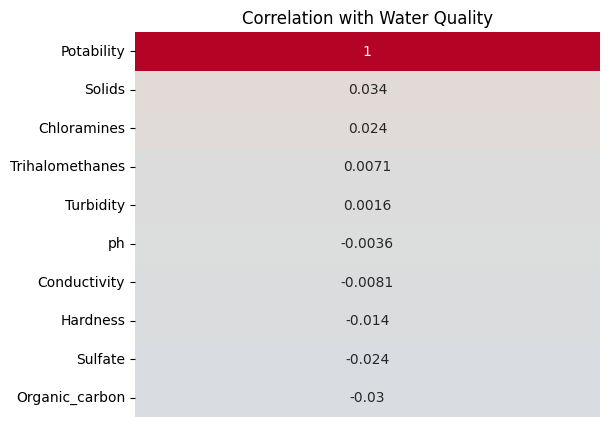

In [ ]:
numeric_cols = df.select_dtypes(include=['number']).columns
corr_matrix = df[numeric_cols].corr()
corr_target = corr_matrix['Potability'].sort_values(ascending=False)
corr_with_target = pd.DataFrame(corr_target)

plt.figure(figsize=(6, len(corr_with_target)/2))  
sns.heatmap(corr_with_target, annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar=False)
plt.title('Correlation with Water Quality')
plt.yticks(rotation=0)
plt.xticks([])  
plt.show()


## 🎯 Feature Selection Based on Correlation  

- Select features with **correlation greater than 0.25**.  
- Exclude the **target column (`Potability`)** from the selection.  

This helps in identifying the most relevant predictors for water quality analysis.


In [ ]:
important_features = corr_target[corr_target > -0.95].index.tolist()
important_features = [feat for feat in important_features if feat != 'Water Quality']
print("Important features:", important_features)

Important features: ['Potability', 'Solids', 'Chloramines', 'Trihalomethanes', 'Turbidity', 'ph', 'Conductivity', 'Hardness', 'Sulfate', 'Organic_carbon']


In [33]:
print(df.columns.tolist())

['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability']


## 🔎 Checking Zero Values  

Count the number of entries equal to **0** in each column to detect potential data quality issues or special patterns.


In [ ]:
ustunlar = ['ph', 'Hardness', 'Solids','Chloramines','Sulfate', 'Conductivity', 'Organic_carbon','Trihalomethanes', 'Turbidity', 'Potability']

for col in ustunlar:
    zero_count = (df[col] == 0).sum()
    print(f"{col} the number of 0 values in the column: {zero_count}")

ph the number of 0 values in the column: 1
Hardness the number of 0 values in the column: 0
Solids the number of 0 values in the column: 0
Chloramines the number of 0 values in the column: 0
Sulfate the number of 0 values in the column: 0
Conductivity the number of 0 values in the column: 0
Organic_carbon the number of 0 values in the column: 0
Trihalomethanes the number of 0 values in the column: 0
Turbidity the number of 0 values in the column: 0
Potability the number of 0 values in the column: 1998


## 🔄 Replacing Zero Values with NaN  

- Replace all **0 values** in the dataset with `NaN`.  
- Keep the **target column (`Potability`)** unchanged.  

This ensures that zero entries (except in the target) are treated as missing values for proper data cleaning.


In [ ]:
import numpy as np
for col in ustunlar:
    if col != "Potability":  
        df[col] = df[col].replace(0, np.nan)

## 🧹 Handling Missing Values  

- Fill all **NaN values** with the **median** of each column.  
- Using the median is effective for reducing the impact of outliers and maintaining the central tendency of the data.


In [36]:
for col in ustunlar:
    if col != "Potability":
        df[col].fillna(df[col].median(), inplace=True)

C:\Users\Rasulbek_Ruzmetov\AppData\Local\Temp\ipykernel_18740\1498620420.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
C:\Users\Rasulbek_Ruzmetov\AppData\Local\Temp\ipykernel_18740\1498620420.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behav

## ✅ Rechecking the Results  

After handling the missing values, recheck the dataset to ensure that all **NaN entries have been properly filled** and no unexpected issues remain.


In [ ]:
ustunlar = ['ph', 'Hardness', 'Solids','Chloramines','Sulfate', 'Conductivity', 'Organic_carbon','Trihalomethanes', 'Turbidity', 'Potability']

for col in ustunlar:
    zero_count = (df[col] == 0).sum()
    print(f"{col} the number of 0 values in the column: {zero_count}")

ph the number of 0 values in the column: 0
Hardness the number of 0 values in the column: 0
Solids the number of 0 values in the column: 0
Chloramines the number of 0 values in the column: 0
Sulfate the number of 0 values in the column: 0
Conductivity the number of 0 values in the column: 0
Organic_carbon the number of 0 values in the column: 0
Trihalomethanes the number of 0 values in the column: 0
Turbidity the number of 0 values in the column: 0
Potability the number of 0 values in the column: 1998


# ⚙️ Feature Engineering – Created Features

| Feature Name               | Type                  | Reason |
|-----------------------------|----------------------|--------|
| `log_Solids`               | Log-transformed       | Reduces skewness and the impact of outliers in `Solids`. |
| `log_Sulfate`              | Log-transformed       | Normalizes distribution of `Sulfate` for better modeling. |
| `log_Hardness`             | Log-transformed       | Stabilizes variance and reduces extreme values in `Hardness`. |
| `hardness_solid_ratio`     | Ratio                 | Captures the balance between water hardness and total solids. |
| `sulfate_chloramine_ratio` | Ratio                 | Shows the relationship between sulfate concentration and chloramines. |
| `carbon_turbidity_ratio`   | Ratio                 | Reflects the proportion of organic carbon relative to turbidity. |
| `ph_category_neutral`      | Categorical (one-hot) | Identifies if pH is neutral, helping to capture qualitative meaning. |
| `ph_category_alkaline`     | Categorical (one-hot) | Identifies if pH is alkaline, improving interpretability. |
| `conductivity_sulfate`     | Interaction           | Captures combined effect of conductivity and sulfate ions. |
| `hardness_ph`              | Interaction           | Represents interaction between hardness and acidity/alkalinity. |
| `ph_missing`               | Missing indicator     | Flags missing pH values (1 = missing, 0 = not missing). |
| `Sulfate_missing`          | Missing indicator     | Flags missing sulfate values (1 = missing, 0 = not missing). |
| `Trihalomethanes_missing`  | Missing indicator     | Flags missing trihalomethanes values (1 = missing, 0 = not missing). |


🔹 1. Log-transformed features

log_Solids → Log of Solids

log_Sulfate → Log of Sulfate

log_Hardness → Log of Hardness

🔹 2. Ratio features

hardness_solid_ratio = Hardness / Solids

sulfate_chloramine_ratio = Sulfate / Chloramines

carbon_turbidity_ratio = Organic_carbon / Turbidity

🔹 3. pH categories (categorical features)

ph_category_neutral

ph_category_alkaline

🔹 4. Interaction features

conductivity_sulfate = Conductivity × Sulfate

hardness_ph = Hardness × ph

5. Missing value indicators

ph_missing

Sulfate_missing

Trihalomethanes_missing

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# ===================================
# 1. Select required features
# ===================================

features = ['ph', 'Hardness', 'Solids','Chloramines','Sulfate', 
            'Conductivity','Organic_carbon','Trihalomethanes', 'Turbidity']
target = 'Potability'

df = df[features + [target]].copy()   # Keep only selected columns

# ===================================
# 2. Replace zeros with NaN 
# (except for target column)
# ===================================
for col in features:
    df[col] = df[col].replace(0, np.nan)

# ===================================
# 3. Fill missing values with the median
# ===================================
for col in features:
    df[col].fillna(df[col].median(), inplace=True)

# ===================================
# 4. Log-transformation (for large numeric columns)
# ===================================
df["log_Solids"] = np.log1p(df["Solids"])
df["log_Sulfate"] = np.log1p(df["Sulfate"])
df["log_Hardness"] = np.log1p(df["Hardness"])

# ===================================
# 5. Create ratio features
# ===================================
df["hardness_solid_ratio"] = df["Hardness"] / (df["Solids"] + 1)
df["sulfate_chloramine_ratio"] = df["Sulfate"] / (df["Chloramines"] + 1)
df["carbon_turbidity_ratio"] = df["Organic_carbon"] / (df["Turbidity"] + 1)

# ===================================
# 6. pH categorization (acidic / neutral / alkaline)
# ===================================
def ph_category(x):
    if x < 6.5:
        return "acidic"
    elif x <= 8.5:
        return "neutral"
    else:
        return "alkaline"

df["ph_category"] = df["ph"].apply(ph_category)

# One-hot encoding for pH categories
df = pd.get_dummies(df, columns=["ph_category"], drop_first=True)

# ===================================
# 7. Interaction features
# ===================================
df["conductivity_sulfate"] = df["Conductivity"] * df["Sulfate"]
df["hardness_ph"] = df["Hardness"] * df["ph"]

# ===================================
# 8. Missing value indicators
# ===================================
for col in ['ph', 'Sulfate', 'Trihalomethanes']:
    df[col+"_missing"] = df[col].isna().astype(int)

# ===================================
# 9. Feature scaling (normalization)
# ===================================
scaler = StandardScaler()
scaled_cols = features  # Original columns to scale
df[scaled_cols] = scaler.fit_transform(df[scaled_cols])

# ===================================
# Final dataset
# ===================================
print("Final dataset shape:", df.shape)
print(df.head())


Final dataset shape: (3276, 23)
         ph  Hardness    Solids  Chloramines       Sulfate  Conductivity  \
0 -0.001476  0.259195 -0.139471     0.112415  9.613574e-01      1.708954   
1 -2.298971 -2.036414 -0.385987    -0.307694  3.145987e-15      2.062575   
2  0.693860  0.847665 -0.240047     1.360594  3.145987e-15     -0.094032   
3  0.842470  0.547651  0.000493     0.592008  6.395190e-01     -0.778830   
4  1.371969 -0.464429 -0.460249    -0.363698 -6.541765e-01     -0.343939   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  ...  \
0       -1.180651         1.306149  -1.286298           0  ...   
1        0.270597        -0.638480   0.684218           0  ...   
2        0.781117         0.001509  -1.167365           0  ...   
3        1.255134         2.152874   0.848412           0  ...   
4       -0.824357        -2.181599   0.138786           0  ...   

   hardness_solid_ratio  sulfate_chloramine_ratio  carbon_turbidity_ratio  \
0              0.009854              

C:\Users\Rasulbek_Ruzmetov\AppData\Local\Temp\ipykernel_20584\623193601.py:25: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



C:\Users\Rasulbek_Ruzmetov\AppData\Local\Temp\ipykernel_20584\623193601.py:25: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col

In [39]:
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability,...,hardness_solid_ratio,sulfate_chloramine_ratio,carbon_turbidity_ratio,ph_category_alkaline,ph_category_neutral,conductivity_sulfate,hardness_ph,ph_missing,Sulfate_missing,Trihalomethanes_missing
0,-0.026642,0.259195,-0.139471,0.112415,0.965957,1.708954,-1.180651,1.305434,-1.286298,0,...,0.009854,44.398438,2.619084,False,True,207957.017058,1441.900641,0,0,0
1,-2.294380,-2.036414,-0.385987,-0.307694,-0.014799,2.062575,0.270597,-0.639186,0.684218,0,...,0.006947,43.623159,2.759673,False,False,197474.428788,480.945936,0,0,0
2,0.698264,0.847665,-0.240047,1.360594,-0.014799,-0.094032,0.781117,0.000800,-1.167365,0,...,0.011262,32.413129,4.159002,False,True,139426.655657,1816.117313,0,0,0
3,0.846865,0.547651,0.000493,0.592008,0.644130,-0.778830,1.255134,2.152154,0.848412,0,...,0.009736,39.394309,3.275409,False,True,129644.783162,1782.893330,0,0,0
4,1.376330,-0.464429,-0.460249,-0.363698,-0.649522,-0.343939,-0.824357,-2.182297,0.138786,0,...,0.010072,41.096088,2.277460,True,False,123561.431446,1646.615390,0,0,0


In [40]:
df.isnull().sum()

ph                          0
Hardness                    0
Solids                      0
Chloramines                 0
Sulfate                     0
Conductivity                0
Organic_carbon              0
Trihalomethanes             0
Turbidity                   0
Potability                  0
log_Solids                  0
log_Sulfate                 0
log_Hardness                0
hardness_solid_ratio        0
sulfate_chloramine_ratio    0
carbon_turbidity_ratio      0
ph_category_alkaline        0
ph_category_neutral         0
conductivity_sulfate        0
hardness_ph                 0
ph_missing                  0
Sulfate_missing             0
Trihalomethanes_missing     0
dtype: int64

# 📊 Feature Selection Result

After analyzing the correlation heatmap and feature importance, we identified features with **low impact** on the target (`Potability`).  

### 🚫 Low-impact features removed:
- `Trihalomethanes`  
- `Turbidity`  
- `hardness_solid_ratio`  
- `ph`  
- `sulfate_chloramine_ratio`  
- `Conductivity`  

### ✅ New Dataset Shape:
- **(3276, 18)**  

This reduced dataset will help improve **model efficiency** while keeping the most informative features.  


In [ ]:
import pandas as pd

target = "Potability"

corr_matrix = df.corr()

corr_target = corr_matrix[target].sort_values(ascending=False)

threshold = 0.01
low_corr_features = corr_target[abs(corr_target) < threshold].index

print("Low-impact features removed:", list(low_corr_features))

df_reduced = df.drop(columns=low_corr_features)

print(" New dataset  shape:", df_reduced.shape)


Kam ta'sir qilayotgan ustunlar: ['Trihalomethanes', 'Turbidity', 'hardness_solid_ratio', 'ph', 'sulfate_chloramine_ratio', 'Conductivity']
Yangi dataset shape: (3276, 18)


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ph                        3276 non-null   float64
 1   Hardness                  3276 non-null   float64
 2   Solids                    3276 non-null   float64
 3   Chloramines               3276 non-null   float64
 4   Sulfate                   3276 non-null   float64
 5   Conductivity              3276 non-null   float64
 6   Organic_carbon            3276 non-null   float64
 7   Trihalomethanes           3276 non-null   float64
 8   Turbidity                 3276 non-null   float64
 9   Potability                3276 non-null   int64  
 10  log_Solids                3276 non-null   float64
 11  log_Sulfate               3276 non-null   float64
 12  log_Hardness              3276 non-null   float64
 13  hardness_solid_ratio      3276 non-null   float64
 14  sulfate_

### 📊 About Log Transformation  

- ✅ **Log transformation** helps reduce the **right-skewness** in the `Water Quality` variable, making its distribution closer to **normal**.  
- 🚀 This is beneficial for **regression models**, since many of them perform better when the data is approximately **normally distributed**.  
- 📈 As a result, the transformation can improve both **model accuracy** and **interpretability**.  


--- Potability column statistics ---
count    3276.000000
mean        0.390110
std         0.487849
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Potability, dtype: float64




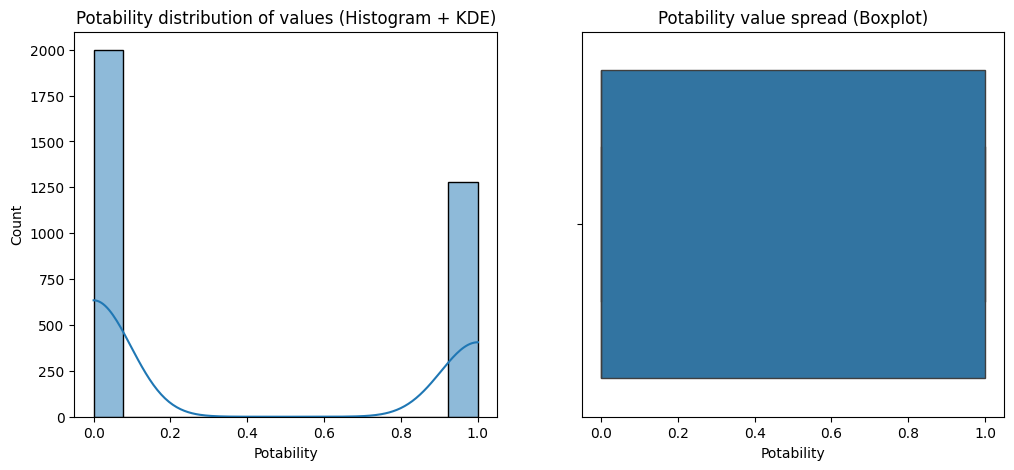

--- After log transformation Potability_log column statistics ---
count    3276.000000
mean        0.270404
std         0.338151
min         0.000000
25%         0.000000
50%         0.000000
75%         0.693147
max         0.693147
Name: Potability_log, dtype: float64




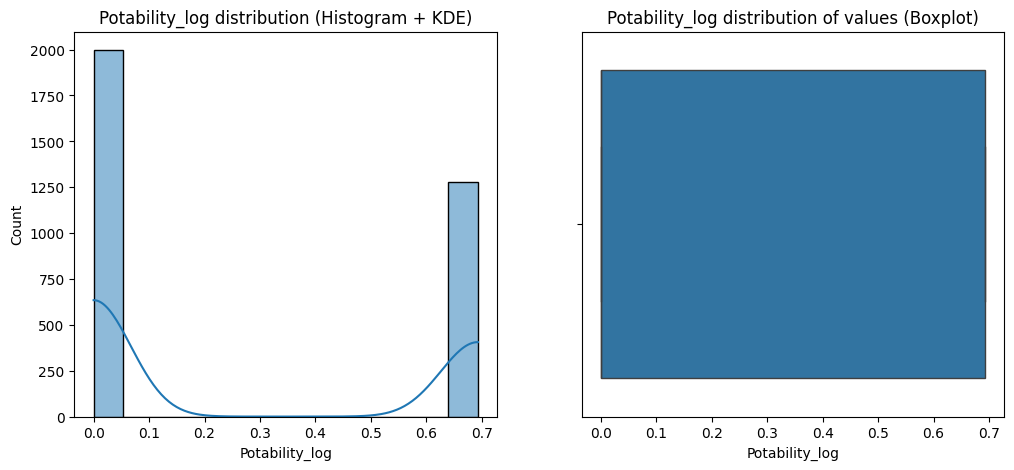

In [41]:

def target_distribution_check(df, target_col):
    print(f"--- {target_col} column statistics ---")
    print(df[target_col].describe())
    print("\n")
    
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    sns.histplot(df[target_col], kde=True)
    plt.title(f'{target_col} distribution of values (Histogram + KDE)')
    
    plt.subplot(1,2,2)
    sns.boxplot(x=df[target_col])
    plt.title(f'{target_col} value spread (Boxplot)')
    
    plt.show()

def log_transform_and_check(df, target_col):
    df[target_col + '_log'] = np.log1p(df[target_col])
    print(f"--- After log transformation {target_col}_log column statistics ---")
    print(df[target_col + '_log'].describe())
    print("\n")
    
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    sns.histplot(df[target_col + '_log'], kde=True)
    plt.title(f'{target_col}_log distribution (Histogram + KDE)')
    
    plt.subplot(1,2,2)
    sns.boxplot(x=df[target_col + '_log'])
    plt.title(f'{target_col}_log distribution of values (Boxplot)')
    
    plt.show()

# Launch:
target_distribution_check(df, 'Potability')

# Check the log transformation if necessary:
log_transform_and_check(df, 'Potability')
